In [1]:
import os

In [2]:
from typing import Annotated

In [4]:
from typing_extensions import TypedDict

In [5]:
from langgraph.graph import StateGraph, START, END

In [6]:
from langgraph.graph.message import add_messages

In [62]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [63]:
graph_builder = StateGraph(State)

In [64]:
from langchain_community.chat_models import ChatZhipuAI

In [13]:
chat_model = ChatZhipuAI(model='glm-4-flash-250414')

In [65]:
def chatbot(state: State):
    return {'messages': [chat_model.invoke(state['messages'])]}

In [66]:
graph_builder.add_node('chatbot', chatbot)

In [67]:
graph_builder.add_edge(START, 'chatbot')
graph_builder.add_edge('chatbot', END)

In [68]:
graph = graph_builder.compile()

In [69]:
from IPython.display import Image, display

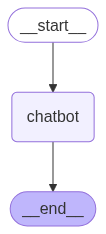

In [70]:
try: 
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [71]:
while True:
    user_input = input("User: ")

    if user_input.lower() in ['quit', 'exit', 'q']:
        print('Goodbye!')
        break

    for event in graph.stream({'messages': ('user', user_input)}):
        for value in event.values():
            print('Assistant:', value["messages"][-1].content)

User:  请给我介绍一下Tavily的主要作用


Assistant: Tavily 是一个专门用于搜索实时信息的数据平台，它主要作用是为用户提供最新的网络信息，帮助用户快速找到最新的新闻、研究论文、博客文章和其他在线资源。Tavily 的特点在于它的搜索引擎能够返回高度相关的结果，同时过滤掉那些过时或不准确的信息。这使得Tavily成为需要最新信息的研究人员、学生、记者和任何需要实时数据的专业人士的有用工具。通过使用Tavily，用户可以确保他们获得的信息是最新的，从而做出更准确、更及时的决策。


User:  q


Goodbye!


In [73]:
import getpass
import os

In [74]:
os.environ.get("TAVILY_API_KEY")

'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'

In [75]:
from langchain_community.tools import TavilySearchResults

In [76]:
tool = TavilySearchResults(max_results=2)

In [78]:
tools = [tool]

In [31]:
tool.invoke("简单介绍一下Tavily")

[{'title': 'Tavily - AI工具信息，评论，替代品',
  'url': 'https://sayhi2.ai/zh/product/tavily_com',
  'content': 'Tavily是一款利用人工智能技术的研究支持平台。 用户可以分享他们的研究目标和问题，并直接获得快速准确的研究结果。 该平台可以应对任何主题或领域的研究需求，并由专家团',
  'score': 0.8886914},
 {'title': 'Tavily: 为AI代理和快速见解量身定制的AI驱动的搜索引擎和研究助手。',
  'url': 'https://www.toolify.ai/zh/tool/gpt-researcher',
  'content': 'Toolify logo\n\n最新上架的AI，每日更新\n\n获得最多收藏的AI工具\n\n网站流量最高的AI工具\n\n按App分类的AI工具\n\nAI的Discord社区\n\n按浏览器插件分类的AI工具\n\n来自GPT Store 的GPTs\n\n依据月份和月访问量划分的AI网站榜单\n\n依据分类和月访问量划分的AI网站榜单\n\n依据地区和月访问量划分的AI网站榜单\n\n依据来源和月访问量划分的AI网站榜单\n\n依据支付排名和实际流量的AI高收入榜\n\n# Tavily\n\n## 什么是Tavily？\n\nTavily是一个为人工智能代理定制的搜索引擎，提供实时、准确的结果、智能查询建议和深入研究能力。它还充当一个AI研究助手，通过收集准确的来源并组织研究结果在一个平台上提供快速的洞察和综合性研究。Tavily帮助个人和企业做出无偏见且经过深思熟虑的决策，通过自动化研究在分钟内提供可操作的见解。\n\n## 如何使用 Tavily？\n\n使用Tavily时，请分享您的目标和问题。Tavily从相关来源收集信息，并在几分钟内将可操作的研究见解直接发送到您的收件箱。该平台还允许反馈、深入研究成果及与团队成员的协作。 [...] ## Tavily 的核心功能\n\n### 实时、准确的搜索结果\n\n### 智能查询建议\n\n### 深入的研究能力\n\n### 为AI代理和大型语言模型量身定制\n\n### 综合来源收集\n\n### 研究结果的组织\n\n### 团队协作

In [79]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [80]:
graph_builder = StateGraph(State)

In [81]:
chat_model = ChatZhipuAI(model='glm-4-flash-250414')

In [82]:
llm_with_tools = chat_model.bind_tools(tools)

In [83]:
def chatbot(state: State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

In [84]:
graph_builder.add_node('chatbot', chatbot)

In [85]:
import json
from langchain_core.messages import ToolMessage

In [86]:
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        # tools 是一个包含所有可用工具的列表，我们将其转化为字典，
        # 通过工具名称（tool.name）来访问具体的工具
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """执行工具调用
        
        参数:
        inputs: 包含 "messages" 键的字典，"messages" 是对话消息的列表，
                其中最后一条消息可能包含工具调用的请求。
        
        返回:
        包含工具调用结果的消息列表
        """
        # 获取消息列表中的最后一条消息，判断是否包含工具调用请求
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("输入中未找到消息")

        # 用于保存工具调用的结果
        outputs = []

        # 遍历工具调用请求，执行工具并将结果返回
        for tool_call in message.tool_calls:
            # 根据工具名称找到相应的工具，并调用工具的 invoke 方法执行工具
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 将工具调用结果作为 ToolMessage 保存下来
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),  # 工具调用的结果以 JSON 格式保存
                    name=tool_call["name"],  # 工具的名称
                    tool_call_id=tool_call["id"],  # 工具调用的唯一标识符
                )
            )
            
         # 返回包含工具调用结果的消息
        return {"messages": outputs}

In [87]:
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [88]:
from typing import Literal

In [89]:
# 定义路由函数，检查工具调用
def route_tools(state: State,) -> Literal["tools", "__end__"]:
    """
    使用条件边来检查最后一条消息中是否有工具调用。
    
    参数:
    state: 状态字典或消息列表，用于存储当前对话的状态和消息。
    
    返回:
    如果最后一条消息包含工具调用，返回 "tools" 节点，表示需要执行工具调用；
    否则返回 "__end__"，表示直接结束流程。
    """
    # 检查状态是否是列表类型（即消息列表），取最后一条 AI 消息
    if isinstance(state, list):
        ai_message = state[-1]
    # 否则从状态字典中获取 "messages" 键，取最后一条消息
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    # 如果没有找到消息，则抛出异常
    else:
        raise ValueError(f"输入状态中未找到消息: {state}")

    # 检查最后一条消息是否有工具调用请求
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 如果有工具调用请求，返回 "tools" 节点
    return "__end__"  # 否则返回 "__end__"，流程结束

In [90]:
graph_builder.add_conditional_edges(
    "chatbot",  # 从聊天机器人节点开始
    route_tools,  # 路由函数，决定下一个节点
    {
        "tools": "tools", 
        "__end__": "__end__"
    },  # 定义条件的输出，工具调用走 "tools"，否则走 "__end__"
)

In [91]:
# 当工具调用完成后，返回到聊天机器人节点以继续对话
graph_builder.add_edge("tools", "chatbot")

In [92]:
# 指定从 START 节点开始，进入聊天机器人节点
graph_builder.add_edge(START, "chatbot")

In [93]:
graph = graph_builder.compile()

In [94]:
from IPython.display import Image, display

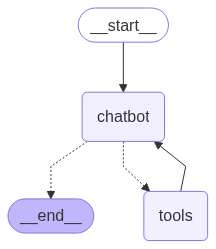

In [95]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print('failed', e)
    pass

In [98]:
from langchain_core.messages import BaseMessage

# 进入一个无限循环，用于模拟持续的对话
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 如果用户输入 "quit"、"exit" 或 "q"，则退出循环，结束对话
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别语
        break  # 退出循环

    # 使用 graph.stream 处理用户输入，并生成机器人的回复
    # "messages" 列表中包含用户的输入，传递给对话系统
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # 遍历 event 的所有值，检查是否是 BaseMessage 类型的消息
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                # 如果消息是 BaseMessage 类型，则打印机器人的回复
                print("Assistant:", value["messages"][-1].content)

User:  请给我介绍一下Tavily的主要作用


Assistant: 
Assistant: [{"title": "tavily\u7684\u7b80\u4ecb\u3001\u5b89\u88c5\u548c\u4f7f\u7528\u65b9\u6cd5\u3001\u6848\u4f8b\u5e94\u7528\u4e4b\u8be6\u7ec6\u653b\u7565 - CSDN\u535a\u5ba2", "url": "https://blog.csdn.net/qq_41185868/article/details/137897454", "content": "\u8f7b\u677e\u5730\u5c06\u667a\u80fd\u641c\u7d22\u529f\u80fd\u96c6\u6210\u5230\u60a8\u7684\u5e94\u7528\u7a0b\u5e8f\u4e2d\uff0c\u5229\u7528Tavily\u5f3a\u5927\u7684\u641c\u7d22\u529f\u80fd\u3002 ... Tavily\u7684\u4e3b\u8981\u7279\u70b9\u662f\u63d0\u4f9b\u9ad8\u6548\u3001\u5feb\u901f\u4e14\u6301\u4e45\u7684\u641c\u7d22\u7ed3\u679c\uff0c\u65e8\u5728\u5e2e\u52a9AI\u5f00\u53d1", "score": 0.86136365}, {"title": "\u3010\u4eba\u5de5\u667a\u80fd\u3011Tavily Search API \uff0c\u4e13\u4e3a\u4eba\u5de5\u667a\u80fd\u4ee3\u7406\uff08\u5982\u5927\u578b\u8bed\u8a00 ...", "url": "https://blog.csdn.net/wstever/article/details/143361668", "content": "Tavily\u662f\u4e00\u4e2a\u4e13\u4e3a\u4eba\u5de5\u667a\u80fd\u4ee3\u7406\uff08\u5982\u5927\

User:  q


Goodbye!
